Let's track the origami data. First, let's import everything that is needed

In [3]:
import numpy as np 
import pandas as pd 
import os 

try:
    data_folder = r'Decirculator/spt/data_spt/Origami/xy_locs'
    from Decirculator.spt.tracking_utils import track_particles, get_deltas_list_origami
except:
    data_folder = r'spt\data_spt\Origami\xy_locs'
    from spt.tracking_utils import track_particles, get_deltas_list_origami


Let's load all the locations from the movie folders


In [4]:
raw_locations = {}
for processed_movie in os.listdir(data_folder):
    raw_locations[processed_movie] = []

    for color_enum, color in enumerate(['green','red','blue']):
        xy_locs = pd.read_csv(os.path.join(data_folder,processed_movie ,str(color)+'_predicted.csv')).to_numpy()
        xy_locs = np.hstack([xy_locs, color_enum*np.ones([xy_locs.shape[0],1])])
        raw_locations[processed_movie].append(xy_locs)

Now, let's track each of the datasets, so that we can produce tracks for each of the individual colors in each of the movies. The tracking requires a few parameters:
- Number of dark frames (mem_frame). -> This is the number of frames that a particle can 'disappear' within the track
- Conjugation radius (radius). -> This is the maximal distance that a particle can travel in between two localizations, even if there are dark frames inbetween.

The tracking is performed by global optimization of the total sum of distances between the candidate positions and previous tracks, which is calculated using a bipartite graph matching algorithm. The distance matrix and assignment takes into account the maximal possible travel distance.

In [5]:
max_distance = 6
mem_frame = 3
start_frame = 60
end_frame   = 300

In [8]:
tracked_particles = {}
for processed_movie in os.listdir(data_folder):
    tracked_particles[processed_movie] = []
    for color_enum, color in enumerate(['green','red','blue']):
        tracked_particles[processed_movie].append(track_particles(raw_locations[processed_movie][color_enum],start_frame, end_frame,mem_frame,max_distance))

100%|██████████| 239/239 [00:01<00:00, 161.74it/s]


Now that we have the tracks, we first need to filter out the non-sensical tracks. These are the tracks that contain <=15 total points. 

In [9]:
track_length = 15

for processed_movie in os.listdir(data_folder):
    for color,_ in enumerate(tracked_particles[processed_movie]):
        tracked_particles[processed_movie][color] = [np.array(p) for p in tracked_particles[processed_movie][color] if len(p)>track_length]

We can proceed and calculate all the statistics. We first should start by calculating the displacement list. These are all displacements with a certain delta t along each of the particles. This takes some time...

During this calculation, we also remove all the particles that don't reach a displacement of 1 micron along their track.

In [10]:

deltas_list_all_colors = []
pixel_size = 0.108 #micron
max_radius = 1 #micron


for color_enum, color in enumerate(['green','red','blue']):
    particles = []
    for key in tracked_particles.keys():
        particles+=tracked_particles[key][color_enum]
    


    deltas_list_all_colors.append(get_deltas_list_origami(particles,pixel_size,max_radius))

Now, we can compute the MSD

1.555230491195075
1.606909803122594
1.6388473146097307


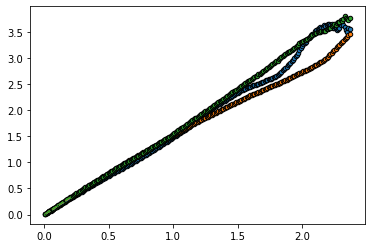

In [12]:
import matplotlib.pyplot as plt
from scipy import stats

circulator_color_dict = {'blue':'orange','red':'green','green':'red'}

for deltas_list in deltas_list_all_colors:
    MSD = []

    for delta in range(1, np.int64(np.max(deltas_list[:,0]))):

        xy = deltas_list[np.where(deltas_list[:,0]==delta)[0],1:3]
        r2 = np.sum(np.power(xy,2),axis=1)

        MSD.append([delta,np.mean( r2)])


    MSD = np.array(MSD)

    res = stats.linregress(MSD[0:20,0]*0.01, MSD[0:20,1]*np.power(0.108,2))
    print(res.slope/4)
    plt.scatter(MSD[:,0]*0.01,MSD[:,1]*np.power(0.108,2),s=20,edgecolors= 'black',label='$D=$'+str('%.2f' % (res.slope/4))+' $\mu$' +'$m^2/s$')
    plt.plot(MSD[0:20,0]*0.01,res.slope*MSD[0:20,0]*0.01+res.intercept,linestyle='--',label='_none')


    MSD[:,0] = MSD[:,0]*0.01
    MSD[:,1] = MSD[:,1]*np.power(0.108,2)


plt.show()